In [1]:
import time
times = []
Beginning = time.time()

In [2]:
import re, pandas as pd, numpy as np
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
from nltk.stem.isri import ISRIStemmer
import os
import stanza
import matplotlib.pyplot as plt

In [3]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Saad\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
# n_workers = max(1, os.cpu_count() // 4)

n_workers = 3
pandarallel.initialize(nb_workers=n_workers, progress_bar=True)
print(f"\nUsing {n_workers} cores for parallel processing")

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/

Using 3 cores for parallel processing


In [5]:
TARGET = 10000
MinimumArabicPercentage = 0.4

print('Loading data …')
df = pd.read_csv('arabic_sentiment_reviews.csv', encoding='utf-8', nrows=TARGET)
print(f'Loaded {len(df):,} rows')

Loading data …
Loaded 10,000 rows


In [6]:
def arabic_ratio(text: str) -> float:
    if not isinstance(text, str) or not text.strip():
        return 0.0
    arabic_len = sum(1 for ch in text if '\u0600' <= ch <= '\u06FF')
    return arabic_len / max(len(text), 1)

print('Applying Arabic-ratio filter …')
df['arabic_ratio'] = df['content'].apply(arabic_ratio)
print(f'Kept {len(df):,} rows after filter')

Applying Arabic-ratio filter …
Kept 10,000 rows after filter


In [7]:
def clean_arabic_text(text: str) -> str:
    if not isinstance(text, str):
        return ''
    text = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', text)   # drop non-Arabic
    text = re.sub(r'\\s+', ' ', text).strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ء", "", text)   # drop hamza
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    return text

In [8]:
def get_char_ngrams(text: str, n: int) -> str:
    """Generate space‑separated character n‑grams from cleaned text."""
    if not isinstance(text, str) or not text.strip():
        return ''
    
    # Re‑use the same cleaning logic for consistency
    cleaned = clean_arabic_text(text)
    
    # Skip if cleaned text is shorter than n
    if len(cleaned) < n:
        return ''
    
    # Sliding‑window n‑grams
    ngrams = [cleaned[i:i+n] for i in range(len(cleaned) - n + 1)]
    return ' '.join(ngrams)

print('Generating character 3‑grams and 4‑grams (non‑parallel) …')
start = time.time()
df['char_3grams'] = df['content'].apply(lambda x: get_char_ngrams(x, 3))
df['char_4grams'] = df['content'].apply(lambda x: get_char_ngrams(x, 4))
elapsed = time.time() - start
times.append([" Caharacter n- grams: ", elapsed])
print(f'Character n‑grams generated in {elapsed:.1f} s')

Generating character 3‑grams and 4‑grams (non‑parallel) …
Character n‑grams generated in 1.6 s


In [9]:
def light_stem(txt: str) -> str:
    import re
    from nltk.tokenize import word_tokenize
    from nltk.stem.isri import ISRIStemmer  # ← import here
    stemmer = ISRIStemmer()                 # ← instantiate here

    if not isinstance(txt, str) or not txt.strip():
        return ''
    txt = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', txt)   # drop non-Arabic
    txt = re.sub(r'\\s+', ' ', txt).strip()
    txt = re.sub("[إأٱآا]", "ا", txt)
    txt = re.sub("ة", "ه", txt)
    txt = re.sub("ى", "ي", txt)
    txt = re.sub("ؤ", "و", txt)
    txt = re.sub("ئ", "ي", txt)
    txt = re.sub("ء", "", txt)   # drop hamza
    txt = re.sub(r'(.)\1{2,}', r'\1\1', txt)

    tokens = word_tokenize(txt)
    
    stems = [stemmer.stem(token) for token in tokens]

    return ' '.join(stems)


start = time.time()
df['text_stem'] = df['content'].parallel_apply(light_stem)
elapsed = time.time() - start
times.append([" Stemming ISRI: ", elapsed])
print(f'Stemming finished in {elapsed:.1f} s  ({len(df):,} rows)')

Stemming finished in 3.0 s  (10,000 rows)


In [10]:
def process_stanza_parallel(text: str) -> pd.Series:
    """
    Initializes a single pipeline for POS and NER and returns both.
    """
    import pandas as pd
    if 'stanza_nlp_pipeline_full' not in globals():
        
        import stanza  
        print("Initializing combined POS/NER pipeline for a new worker...")
        globals()['stanza_nlp_pipeline_full'] = stanza.Pipeline(
            'ar', 
            processors='tokenize,pos,ner',  
            verbose=False,
            download_method=None,
            use_gpu=True
        )
    
    nlp = globals()['stanza_nlp_pipeline_full']
    
    if not isinstance(text, str) or not text.strip():
        return pd.Series(['', ''], index=['pos_tagged', 'ner_tagged'])
    
    doc = nlp(text)
    
    tok_pos_list = []
    for sent in doc.sentences:
        for word in sent.words:
            tok_pos_list.append(f'{word.text}_{word.upos}')
    
    entity_list = []
    for ent in doc.ents:
        entity_list.append(f'{ent.text}_{ent.type}')
    
    return pd.Series([
        '|'.join(tok_pos_list),
        '|'.join(entity_list)
    ], index=['pos_tagged', 'ner_tagged'])

print('Starting parallel POS & NER tagging...')
start_stanza = time.time()

df[['pos_tagged', 'ner_tagged']] = df['content'].parallel_apply(process_stanza_parallel)

elapsed_stanza = time.time() - start_stanza
times.append([" Tagging POS & NER Stanza: ", elapsed_stanza])
print(f'Stanza (POS & NER) tagging finished in {elapsed_stanza:.1f} s')

Starting parallel POS & NER tagging...


Stanza (POS & NER) tagging finished in 2333.2 s


In [11]:
df = df.drop(['content'], axis=1)

In [12]:
df.head()

,label,arabic_ratio,char_3grams,char_4grams,text_stem,pos_tagged,ner_tagged
0,1,0.818898,الن لنع نعا عال ال ل ا ال الم لمر مري ريح يح...,النع لنعا نعال عال ال ا ل ال الم المر لمري م...,نعل ريح ردي هذه نعل كثر فهي دفي ريح سعر عقل لج...,النعال_NOUN|المريحة_ADJ|:_PUNCT|أرتدي_VERB|هذه...,
1,1,0.795964,منت نتج تج ج ج جم جمي ميل يل ل ، ، ، خ خ...,منتج نتج تج ج ج جم جمي جميل ميل يل ، ل ، ...,نتج جمل ، خدم سيه لقد شري زوج من نعل باو لدب ت...,منتج_NOUN|جميل_ADJ|،_PUNCT|خدمة_NOUN|سيئة_ADJ|...,Clau_MISC|sette_MISC
2,1,0.806202,جيد يد د ل لل للا لاش اشي شيا يا ا ا ال ال...,جيد يد ل د لل للا للاش لاشي اشيا شيا يا ا ا...,جيد اشا صغر هذا عمل شكل جيد لقط قطع صغر من جوه...,جيد_ADJ|ل_ADP|الأشياء_NOUN|الصغيرة_ADJ|:_PUNCT...,
3,0,0.731343,واه اهي هيه يه ه ل لل للغ لغا غاي ايه يه ه ...,واهي اهيه هيه يه ل ه لل للغ للغا لغاي غايه ا...,وهي غيه flimsyif غيه ، فنت شري ، كن حذر جدا غي...,و_CCONJ|أهية_NOUN|ل_ADP|الغاية_NOUN|:_PUNCT|fl...,flimsyif_MISC
4,1,0.689420,Pop op p f fo for or r G Gi Gir irl rls ls...,Pop op f p fo for for or G r Gi Gir Girl i...,Pop for Girls and Girly Boys ، شخص الذين يحب ض...,Pop_X|for_PUNCT|Girls_X|and_PUNCT|Girly_X|Boys...,Girls and Girly Boys_MISC


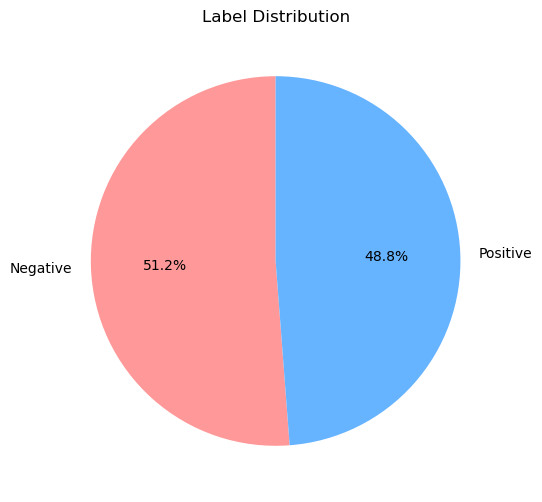

In [13]:
label_counts = df['label'].value_counts()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=label_counts.index.map({0: 'Negative', 1: 'Positive'}),  # optional label names
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999', '#66b3ff']  # optional colors
)

plt.title('Label Distribution')
plt.show()

In [14]:
out_file = 'arabic_pos_ner_tagged.csv'
df.to_csv(out_file, index=False, encoding='utf-8')
print(f'Saved → {out_file}  ({len(df):,} rows)')


Saved → arabic_pos_ner_tagged.csv  (10,000 rows)


In [15]:
Final = time.time()
times.append(["Overall", Final - Beginning])

In [16]:
print(f"n_rows: {TARGET}\n")
print("Times for POS_Tagging Processing")
for i in times:
    print(f"⏱️ {i[0]} : {i[1]:.6} seconds")

n_rows: 10000

Times for POS_Tagging Processing
⏱️  Caharacter n- grams:  : 1.57186 seconds
⏱️  Stemming ISRI:  : 2.9755 seconds
⏱️  Tagging POS & NER Stanza:  : 2333.19 seconds
⏱️ Overall : 2343.59 seconds
